# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import backend
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from ipynb.fs.full.utils import *

# Variables Initialization and Data Description

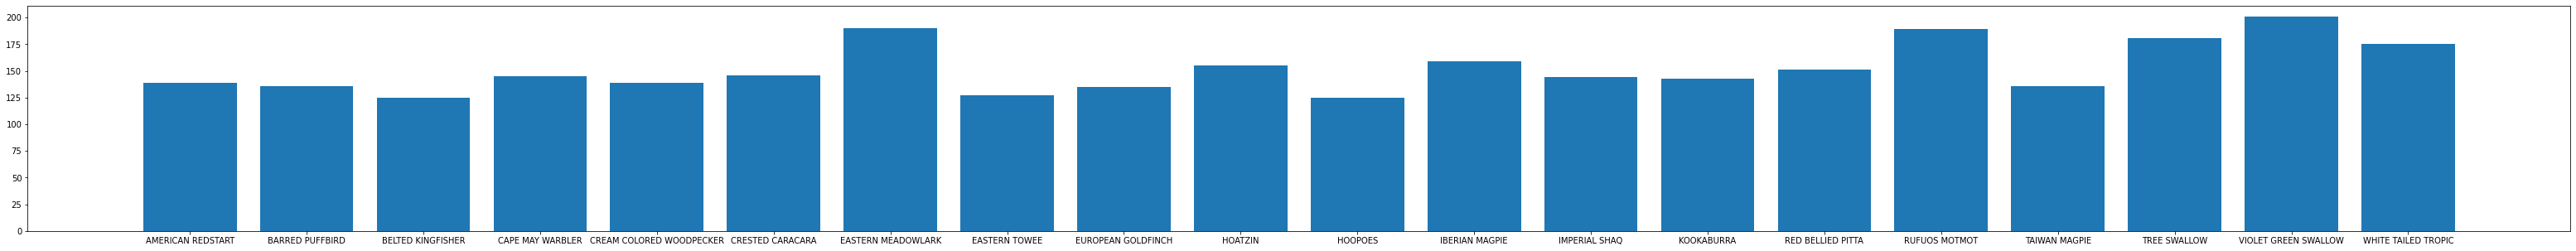

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

describe_data();

# Prepare Generators and Variables Initialization

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


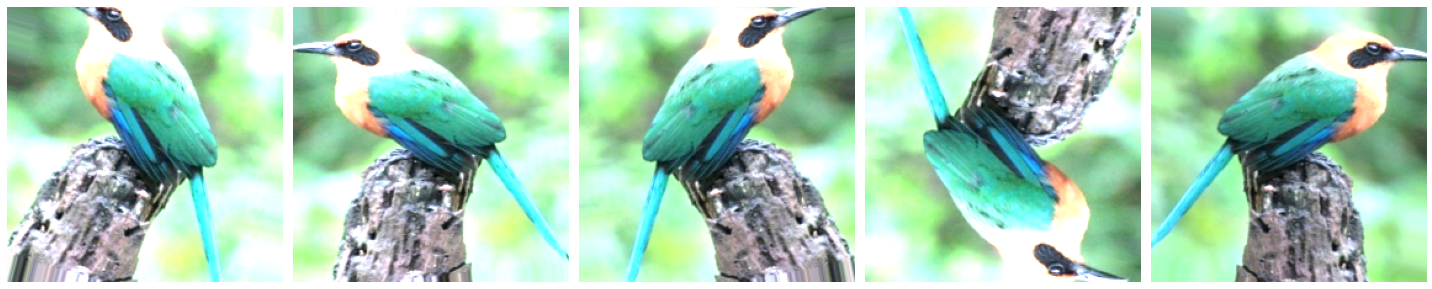

In [3]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255, # normalization
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.5, 2.0]
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Declare callbacks and functions

In [4]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath='./checkpoints/birds.model.hdf5', save_best_only=True)

def evaluate(model, optimizer):
  test_loss, test_acc = model.evaluate(test_generator)
  result = "Using " + optimizer + " We obtained: " + "Test Accuracy:", test_acc, "Test Loss:", test_loss
  print(result)
  return result

# Build model and train model

In [5]:
base_vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Freezing the weights
for layer in base_vgg16.layers:
    layer.trainable = False

base_vgg16.summary();

# use “get_layer” method to save the last layer of the network
last_layer = base_vgg16.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

x = Dropout(0.2)(x)

# add our new softmax layer with 3 hidden units
x = Dense(nr_birds, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_vgg16.input, outputs=x)

# print the new_model summary
new_model.summary()

2022-05-09 12:30:08.268228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 12:30:08.268314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                   

In [6]:
new_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
AdamHistory = new_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, 
                            callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])
AdamTestResult = evaluate(new_model, "Adam")

backend.clear_session()

new_model.compile(SGD(lr=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
SgdHistory = new_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])
SgdTestResult = evaluate(new_model, "SGD")

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30


2022-05-09 12:30:10.851723: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-09 12:30:11.213655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 2.1029 - accuracy: 0.4265

2022-05-09 12:31:06.687802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 58s 592ms/step - loss: 2.1029 - accuracy: 0.4265 - val_loss: 0.7377 - val_accuracy: 0.7700
Epoch 2/30
96/96 [==============================] - 63s 651ms/step - loss: 1.0020 - accuracy: 0.6968 - val_loss: 0.5961 - val_accuracy: 0.8200
Epoch 3/30
96/96 [==============================] - 71s 734ms/step - loss: 0.7555 - accuracy: 0.7695 - val_loss: 0.5276 - val_accuracy: 0.8300
Epoch 4/30
96/96 [==============================] - 79s 820ms/step - loss: 0.6577 - accuracy: 0.7997 - val_loss: 0.6320 - val_accuracy: 0.7800
Epoch 5/30
96/96 [==============================] - 109s 1s/step - loss: 0.6066 - accuracy: 0.8195 - val_loss: 0.3653 - val_accuracy: 0.8800
Epoch 6/30
96/96 [==============================] - 120s 1s/step - loss: 0.4546 - accuracy: 0.8547 - val_loss: 0.2639 - val_accuracy: 0.9100
Epoch 7/30
96/96 [==============================] - 136s 1s/step - loss: 0.4345 - accuracy: 0.8708 - val_loss: 0.3170 - val_accuracy: 0.8700
Epoch 8/30
96/96

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30


2022-05-09 13:47:13.185042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9579

2022-05-09 13:49:51.145175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 164s 2s/step - loss: 0.1342 - accuracy: 0.9579 - val_loss: 0.2570 - val_accuracy: 0.9400
Epoch 2/30
96/96 [==============================] - 157s 2s/step - loss: 0.1090 - accuracy: 0.9609 - val_loss: 0.2613 - val_accuracy: 0.9400
Epoch 3/30
96/96 [==============================] - 148s 2s/step - loss: 0.0991 - accuracy: 0.9661 - val_loss: 0.2227 - val_accuracy: 0.9500
Epoch 4/30
96/96 [==============================] - 144s 2s/step - loss: 0.1128 - accuracy: 0.9615 - val_loss: 0.2548 - val_accuracy: 0.9300
Epoch 5/30
96/96 [==============================] - 147s 2s/step - loss: 0.0919 - accuracy: 0.9701 - val_loss: 0.2556 - val_accuracy: 0.9400
Epoch 6/30
96/96 [==============================] - 146s 2s/step - loss: 0.1013 - accuracy: 0.9668 - val_loss: 0.2221 - val_accuracy: 0.9400
Epoch 7/30
96/96 [==============================] - 143s 1s/step - loss: 0.1034 - accuracy: 0.9688 - val_loss: 0.2349 - val_accuracy: 0.9400
Epoch 8/30
96/96 [======

# Print test results

In [7]:
print(SgdTestResult)
print(AdamTestResult)

('Using SGD We obtained: Test Accuracy:', 0.9199999570846558, 'Test Loss:', 0.22086302936077118)
('Using Adam We obtained: Test Accuracy:', 0.9199999570846558, 'Test Loss:', 0.28914928436279297)


# Graphs

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_26114/3882827249.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


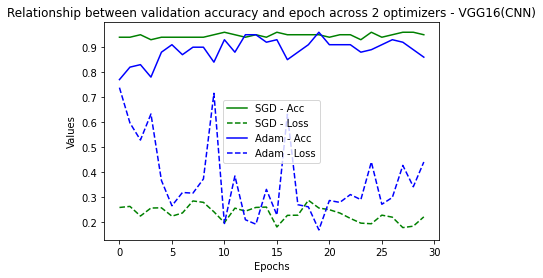

In [8]:
def plotOptimizer():
  fig = plt.figure()
  plt.plot(SgdHistory.history['val_accuracy'], 'g', label='SGD - Acc')
  plt.plot(SgdHistory.history['val_loss'], 'g',  linestyle = 'dashed', label = 'SGD - Loss')
  plt.plot(AdamHistory.history['val_accuracy'], 'b', label='Adam - Acc')
  plt.plot(AdamHistory.history['val_loss'], 'b',  linestyle = 'dashed', label='Adam - Loss')

  plt.title('Relationship between validation accuracy and epoch across 2 optimizers - VGG16(CNN)')
  plt.xlabel('Epochs')
  plt.ylabel('Values')
  plt.legend()
  return fig

fig = plotOptimizer()
fig.show()

In [9]:
def plot_loss_acc(history, label):
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  acc_values = history_dict["accuracy"]
  val_acc_values = history_dict["val_accuracy"]
  epochs = range(1, len(history_dict["accuracy"]) + 1)

  plt.figure(facecolor="w")
  plt.plot(epochs, loss_values, "b",marker="o", label="train")
  plt.plot(epochs, val_loss_values, "b", label="valid")
  plt.title("Loss - " + label)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure(facecolor="w")
  plt.plot(epochs, acc_values, "b", marker="o", label="train")
  plt.plot(epochs, val_acc_values, "b", label="valid")
  plt.title("Accuracy - " + label)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  import numpy as np
  print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
  print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

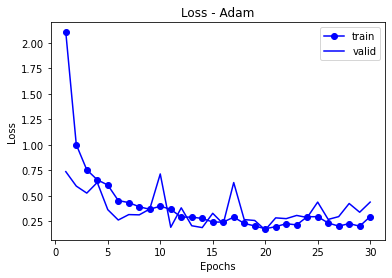

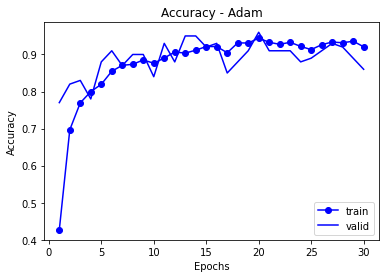

best val_acc: 0.9599999785423279 epoch: 19
best val_loss: 0.1669750213623047 epoch: 19


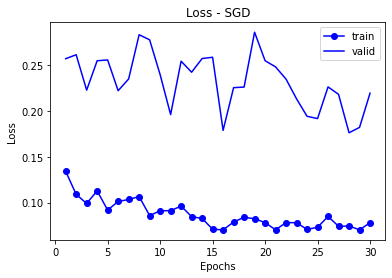

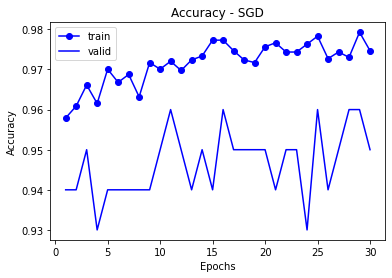

best val_acc: 0.9599999785423279 epoch: 10
best val_loss: 0.17622306942939758 epoch: 27


In [10]:
plot_loss_acc(AdamHistory, "Adam")
plot_loss_acc(SgdHistory, "SGD")

# Save Model

In [11]:
new_model.save('./models/vgg16_model.h5')

## Running Predictions From Saved Model

In [12]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(sorted(os.listdir(train_path))))
  for i, pred in enumerate(predicted_arr):
    confidence = np.round(np.max(pred) * 100, 2)
    return (all_birds_cat[np.argmax(pred)], confidence)


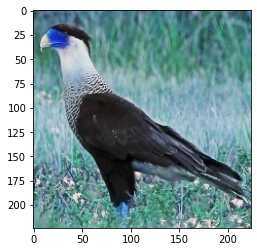

CRESTED CARACARA with 100.0% confidence


2022-05-09 15:09:36.640644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
import tensorflow as tf

model = tf.keras.models.load_model('./models/vgg16_model.h5')

predict_image_path = './dataset/20test/CRESTED CARACARA/1.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

predictions = model.predict(img)
label, confidence = decode(predictions)

print(label + ' with ' + str(confidence) + '% confidence')